# Direct Object Detection from Query

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from astropy.visualization import (MinMaxInterval, ImageNormalize)
from astropy.io import fits as fits
from astropy.coordinates import SkyCoord

import sep
sep.set_extract_pixstack(1000000)

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np
from dl import authClient as ac, queryClient as qc
import pandas as pd

/Users/vernica/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Image Query
Querying a single image from the DESI legacy survey. 

In [ ]:
def query_bricks(ra, dec, dist):
    """Queries the Astro Data Lab for brick names and associated RA/DEC based on the given RA/DEC
    
    dist is in degrees
    """
    
    # one RA/DEC pair, then some set range around that?
    ra_max = ra + dist
    ra_min = ra - dist
    dec_max = dec + dist
    dec_min = dec - dist

    query = f"""
    SELECT brickname, ls_id, ra, dec, mag_g, maskbits, ngood_g
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_g > 0
    AND mag_g <= 21
    AND brickname = '2139p192'
    AND snr_g >= 1
    AND psfdepth_g > 0
    """

    print(query)
    
    print("Querying the Astro Data Lab...")
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    
    return brick_info

brick_df = query_bricks(213.9167, 19.1822, 0.125)

# bright = []

# for row, d in enumerate(brick_df['mag_g']):
#     if d == min(brick_df['mag_g']):
#         bright_ra = (brick_df['ra'].iloc[row])
#         bright_dec = (brick_df['dec'].iloc[row])
#         mag = (brick_df['mag_g'].iloc[row])
#         bright.append([bright_ra, bright_dec, mag])
# bright

for row, d in enumerate(brick_df['ls_id']):
    if d == 10995577790661933:
        arcturus = (brick_df.iloc[row])


    SELECT brickname, ls_id, ra, dec, mag_g, maskbits, ngood_g
    FROM ls_dr10.tractor_s
    WHERE ra >= (213.7917) AND ra < (214.0417)
    AND dec >= (19.0572) AND dec < (19.3072)
    AND mag_g > 0
    AND mag_g <= 21
    AND brickname = '2139p192'
    AND snr_g >= 1
    AND psfdepth_g > 0
    
Querying the Astro Data Lab...


213.8987569233394

Radius-Magnitude Relation 

In [29]:
def mask_radius_for_mag(mag):
    # Returns a masking radius in degrees for a star of the given magnitude.
      # This is in degrees.
    return 1630./3600. * 1.396**(-mag)

rad = mask_radius_for_mag(brick_df['mag_g'])
max(rad)*3600

9.342208672608644

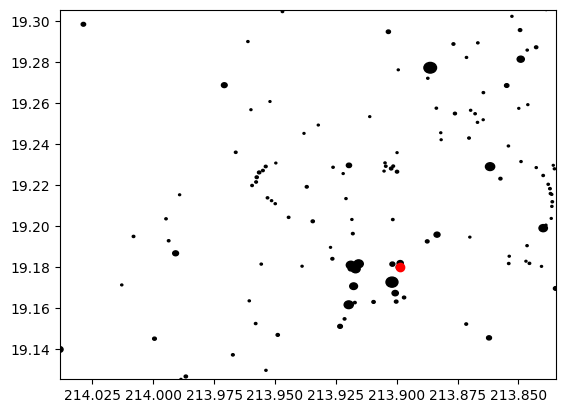

In [39]:
fig, ax = plt.subplots()
ax.set_xlim((max(brick_df['ra']),min(brick_df['ra'])))
ax.set_ylim((min(brick_df['dec']),max(brick_df['dec'])))

for x, y, r in zip(brick_df['ra'], brick_df['dec'], rad):
    c = plt.Circle((x,y), r, color='black', fill='false')
    ax.add_patch(c)

plt.scatter(arcturus['ra'], arcturus['dec'], color='red')

plt.show()

## Finding Dark Regions
Now expand the exclusion zones to a 20 arcsec radius around each object. The centre of the 2.3 FOV cannot be within these exclusion zones. We also add a grid with 45 arcsec diameter squares to demonstrate all the potential centres of the 2.3m FOV.

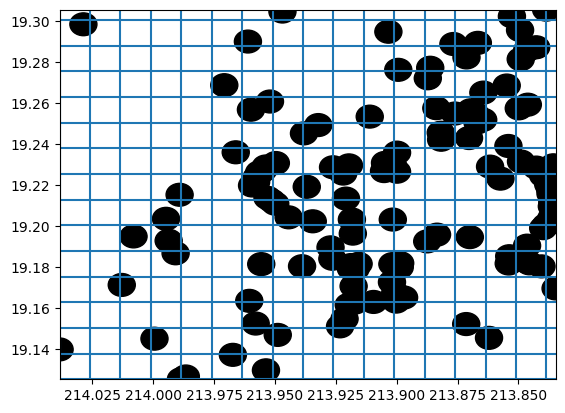

In [7]:
ra = brick_df['ra']
dec = brick_df['dec']

def create_grid():

    # Creating exclusion map with grid
    fig = plt.figure()
    ax = fig.add_subplot(111)


    ax.set_xlim((max(ra),min(ra)))
    ax.set_ylim((min(dec),max(dec)))

    for x, y, r in zip(ra, dec, rad):
        c = plt.Circle((x,y), 0.005556, color='black', fill='false')
        ax.add_patch(c)

    plt.vlines(np.arange(max(ra),min(ra),(-45/3600)), min(dec), max(dec))
    plt.hlines(np.arange(min(dec),max(dec),(45/3600)), max(ra), min(ra))
    plt.margins(0)
    plt.show()

    return

create_grid()

The final step is to find the centre coordinate of every single grid square that does not have any exclusion zone in it. In this case, it is all squares except the bottom left corner. We locate these centres and plot an 'x' on each RADEC coordinate for dark sky regions.

In [8]:
def find_dark_regions():

    # calculating and storing the centre of each dark coord
    centers = []

    for i in range(len(gridlines[:-1])):
        centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

    x_cen, y_cen = np.meshgrid(centers, centers)

    dark_regions = []

    for i in range(len(gridlines) - 1):
        for j in range(len(gridlines) - 1):
            x_start, x_end = gridlines[i], gridlines[i + 1]
            y_start, y_end = gridlines[j], gridlines[j + 1]
            
            if np.all(excl_map[y_start:y_end, x_start:x_end] == 0):
                dark_regions.append([x_cen[j, i], y_cen[j, i]])

    dr_trans = np.array(dark_regions).transpose()

    return dr_trans

dr_trans = find_dark_regions()

NameError: name 'gridlines' is not defined

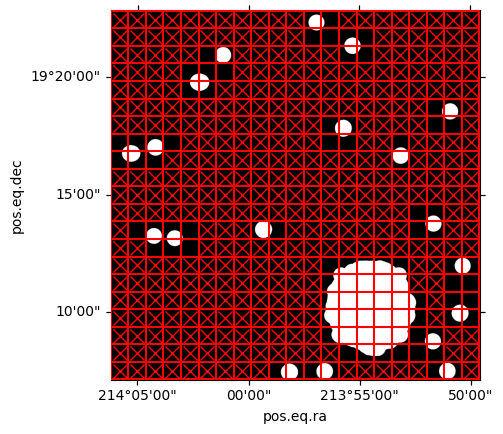

In [29]:
def plot_dark_regions():
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=wcs)

    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_major_formatter('dd:mm:ss')
    lat.set_major_formatter('dd:mm:ss')
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)

    norm = ImageNormalize(excl_map, MinMaxInterval())
    plt.imshow(excl_map, origin='lower', cmap='gray', aspect='equal', norm=norm)
    plt.vlines(gridlines,0,3600,colors='red')
    plt.hlines(gridlines,0,3600,colors='red')
    plt.margins(0)
    plt.plot(dr_trans[0], dr_trans[1], 'rx', markersize=10)
    plt.show()

    return

plot_dark_regions()

In [30]:
def dr_dataframe():

    # list of dark sky coords
    dark_x = []
    dark_y = []

    for i in range(len(dr_trans[0])):
        dark_x.append(dr_trans[1][i]*pixscale + ra)
        dark_y.append(dr_trans[0][i]*pixscale + dec)

    dark_coords = [dark_x, dark_y]

    ra_coords = []
    dec_coords = []

    c = SkyCoord(ra=dark_coords[0], dec=dark_coords[1], unit='arcsec')
    for i in range(len(c)):
        ra_coords.append(c[i].ra.degree)
        dec_coords.append(c[i].dec.degree)

    # create a data frame of coords list
    d = {'RA':ra_coords, 'DEC':dec_coords}
    df = pd.DataFrame(data=d)
    
    return df

df = dr_dataframe()

df
len(df)

347